In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

# Define model

In [4]:
model_1_cube = FBRestNet(
    model_id = 'model_1_cube_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(2000,50,1,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=0.1, 
    nb_epochs=130,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=False
    )

In [5]:
# Generate datasets with different noise levels
generator=torch.Generator()
model_1_cube.noise = 0.01
generator.manual_seed(42)
train_set_1_cube_sigma01, val_set_1_cube_sigma01 = model_1_cube.CreateDataSet(generator)

model_1_cube.noise = 0.05
generator.manual_seed(42)
train_set_1_cube_sigma05, val_set_1_cube_sigma05 = model_1_cube.CreateDataSet(generator)

model_1_cube.noise = 0.1
generator.manual_seed(42)
train_set_1_cube_sigma1, val_set_1_cube_sigma1 = model_1_cube.CreateDataSet(generator)

model_1_cube.noise = 0.5
generator.manual_seed(42)
train_set_1_cube_sigma5, val_set_1_cube_sigma5 = model_1_cube.CreateDataSet(generator)

In [6]:
pretrained_models_list = ['sigma_001_','sigma_005_','sigma_01_','sigma_05_']
noise_list = [0.01, 0.05, 0.1, 0.5]

loss_model_noise = np.zeros((4,4))
signals_001 = [[],[],[],[]]
signals_005 = [[],[],[],[]]
signals_01  = [[],[],[],[]]
signals_05  = [[],[],[],[]]

for i,pretrained_model in enumerate(pretrained_models_list):
    model_1_cube.model.load_state_dict(torch.load(model_1_cube.model_folder+model_1_cube.model_id+pretrained_model+'weights.pt', map_location=torch.device('cpu')))
    model_1_cube.noise = noise_list[i]
    # Test the model on every dataset
    loss_model_noise[i,0], signals_001[i] = model_1_cube.test(val_set_1_cube_sigma01,plot_opt=False, idx=0)
    loss_model_noise[i,1], signals_005[i] = model_1_cube.test(val_set_1_cube_sigma05,plot_opt=False, idx=0)
    loss_model_noise[i,2], signals_01[i] = model_1_cube.test(val_set_1_cube_sigma1,plot_opt=False, idx=0)
    loss_model_noise[i,3], signals_05[i] = model_1_cube.test(val_set_1_cube_sigma5,plot_opt=False, idx=0)

In [7]:
print(' sigma=0.01  sigma=0.05  sigma=0.1  sigma=0.5')
print(loss_model_noise)

 sigma=0.01  sigma=0.05  sigma=0.1  sigma=0.5
[[0.00314984 0.04712813 0.15180276 1.05323935]
 [0.00989696 0.01720603 0.03737576 0.41608179]
 [0.01732361 0.02055689 0.03008459 0.26458526]
 [0.06196488 0.06827795 0.09309779 0.48953873]]


In [8]:
signals_001[0].keys()

dict_keys(['x_elt_true', 'x_elt_init', 'x_elt_pred', 'x_eig_true', 'x_eig_init', 'x_eig_pred'])

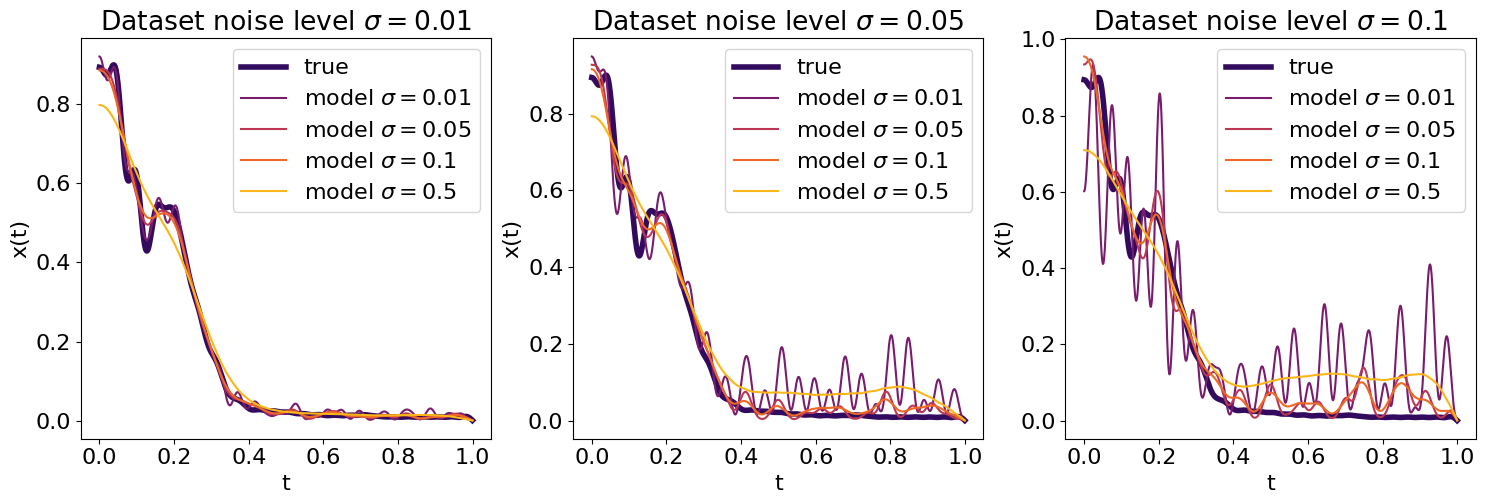

In [9]:
mpl.rcParams.update({'font.size': 16})
t = np.linspace(0,1,model_1_cube.physics.nx,endpoint=False)
fig, ax = plt.subplots(1,3,figsize=(18,5.2))

ax[0].plot(t,signals_001[0]['x_elt_true'], 
    color=sns.color_palette('inferno',n_colors=5)[0], linewidth=4, label=r'true')
ax[0].plot(t,signals_001[0]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[1], label=r'model $\sigma = 0.01$')
ax[0].plot(t,signals_001[1]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[2], label=r'model $\sigma = 0.05$')
ax[0].plot(t,signals_001[2]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[3], label=r'model $\sigma = 0.1$')
ax[0].plot(t,signals_001[3]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[4], label=r'model $\sigma = 0.5$')
ax[0].set_title(r'Dataset noise level $\sigma = 0.01$')
ax[0].legend()
ax[0].set_xlabel('t')
ax[0].set_ylabel('x(t)')


ax[1].plot(t,signals_005[0]['x_elt_true'], 
    color=sns.color_palette('inferno',n_colors=5)[0], linewidth=4, label=r'true')
ax[1].plot(t,signals_005[0]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[1], label=r'model $\sigma = 0.01$')
ax[1].plot(t,signals_005[1]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[2], label=r'model $\sigma = 0.05$')
ax[1].plot(t,signals_005[2]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[3], label=r'model $\sigma = 0.1$')
ax[1].plot(t,signals_005[3]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[4], label=r'model $\sigma = 0.5$')
ax[1].set_title(r'Dataset noise level $\sigma = 0.05$')
ax[1].legend()
ax[1].set_xlabel('t')
ax[1].set_ylabel('x(t)')


ax[2].plot(t,signals_01[0]['x_elt_true'], 
    color=sns.color_palette('inferno',n_colors=5)[0], linewidth=4, label=r'true')
ax[2].plot(t,signals_01[0]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[1], label=r'model $\sigma = 0.01$')
ax[2].plot(t,signals_01[1]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[2], label=r'model $\sigma = 0.05$')
ax[2].plot(t,signals_01[2]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[3], label=r'model $\sigma = 0.1$')
ax[2].plot(t,signals_01[3]['x_elt_pred'], 
    color=sns.color_palette('inferno',n_colors=5)[4], label=r'model $\sigma = 0.5$')
ax[2].set_title(r'Dataset noise level $\sigma = 0.1$')
ax[2].legend()
ax[2].set_xlabel('t')
ax[2].set_ylabel('x(t)')


# ax[3].plot(t,signals_05[0]['x_elt_true'], 
#     color=sns.color_palette('inferno',n_colors=5)[0], linewidth=4, label=r'true')
# ax[3].plot(t,signals_05[0]['x_elt_pred'], 
#     color=sns.color_palette('inferno',n_colors=5)[1], label=r'model $\sigma = 0.01$')
# ax[3].plot(t,signals_05[1]['x_elt_pred'], 
#     color=sns.color_palette('inferno',n_colors=5)[2], label=r'model $\sigma = 0.05$')
# ax[3].plot(t,signals_05[2]['x_elt_pred'], 
#     color=sns.color_palette('inferno',n_colors=5)[3], label=r'model $\sigma = 0.1$')
# ax[3].plot(t,signals_05[3]['x_elt_pred'], 
#     color=sns.color_palette('inferno',n_colors=5)[4], label=r'model $\sigma = 0.5$')
# ax[3].set_title(r'Dataset noise level $\sigma = 0.5$')
# ax[3].legend()
# ax[3].set_xlabel('t')
# ax[3].set_ylabel('x(t)')
plt.savefig('../Figures/Figure_noise_robustness_bigfont.pdf')
plt.show()
